# Chroma Vector Database_ViT-S/16

## 1. Setting

chromadb: Chroma Vector Database로, 음악 정보 검색 및 이미지 처리 및 분석을 위한 패키지입니다.
transformers: Hugging Face에서 제공하는 Transformers 라이브러리로, 자연어 처리 모델을 쉽게 사용할 수 있도록 해주는 패키지입니다.

In [11]:
!pip install -q chromadb transformers

## 2. Dataset
https://www.kaggle.com/datasets/trolukovich/food11-image-dataset

In [8]:
!wget -q https://github.com/kairess/toy-datasets/raw/master/Food-11.zip

!unzip -q Food-11.zip

replace __MACOSX/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/test/._Noodles-Pasta? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/test/._Egg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/test/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/test/._Meat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/test/._Dessert? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/test/._Rice? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/test/._Vegetable-Fruit? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/test/._Seafood? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/test/._Dairy product? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/test/._Bread? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/test/._Soup? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/test/._Fried food? [y]es, [n]o, [A]ll, [N]on

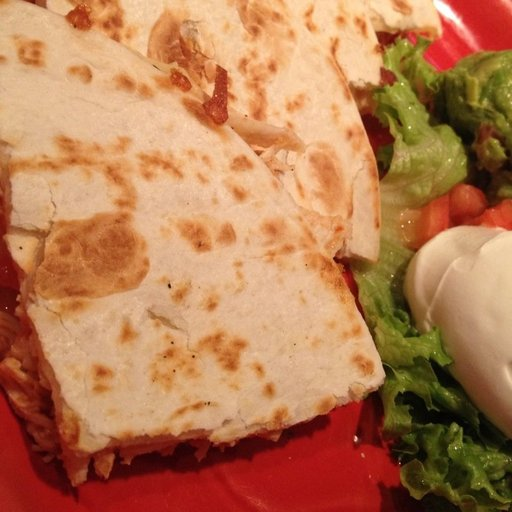

In [9]:
from PIL import Image

# test 데이터에서 bread 0번 이미지 출력
img = Image.open("test/Bread/0.jpg")

img

## 3. 이미지 벡터화 : Image Vectorizer Model load

In [12]:
from transformers import ViTFeatureExtractor, ViTModel

# 이미지를 처리하고 모델 입력에 맞게 토큰화
feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vits16')

# dino-vits16 모델 로드 및 GPU 적용
model = ViTModel.from_pretrained('facebook/dino-vits16').to("cuda")

print("모델 로드가 완료되었습니다!")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델 로드가 완료되었습니다!


## 4. Embedding

In [13]:
from glob import glob

img_list = sorted(glob("test/*/*.jpg"))

len(img_list)

110

In [16]:
from tqdm import tqdm

embeddings = []
metadatas = []
ids = []

# 파일 별 이미지 불러오기 & 읽기
for i, img_path in enumerate(tqdm(img_list)):
    img = Image.open(img_path) # 이미지 읽기
    cls = img_path.split("/")[1] # 폴더를 구분, 인덱싱

    # 이미지를 텐서로 반환
    img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
    outputs = model(**img_tensor)

    # 텐서를 임베딩, 텐서를 NumPy 배열로 변환하고 1차원 축소
    embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()
    embedding_to_list = embedding.tolist()

    embeddings.append(embedding_to_list) # 결과를 여기에 넣겠다.

    # 이미지의 메타데이터를 딕셔너리로 구성하여 메타데이터 리스트에 추가
    metadatas.append({
        "uri": img_path,
        "name": cls
    })

    # 각 이미지에 대한 고유한 ID를 리스트에 추가
    ids.append(str(i))

print("Done!")

100%|██████████| 110/110 [00:02<00:00, 46.98it/s]

Done!


## 5. chromadb

chromadb에 클라이언트로 접근 후 사전 작업한 임베딩 값을 만들어놓은 collection 변수 즉 DB에 저장합니다.

In [14]:
import chromadb

client = chromadb.Client()

collection = client.create_collection("foods")

In [17]:
collection.add(
    embeddings=embeddings,
    metadatas=metadatas,
    ids=ids,
)

## 6. Model Test

테스트를 위해 불러온 이미지를 확인합니다.

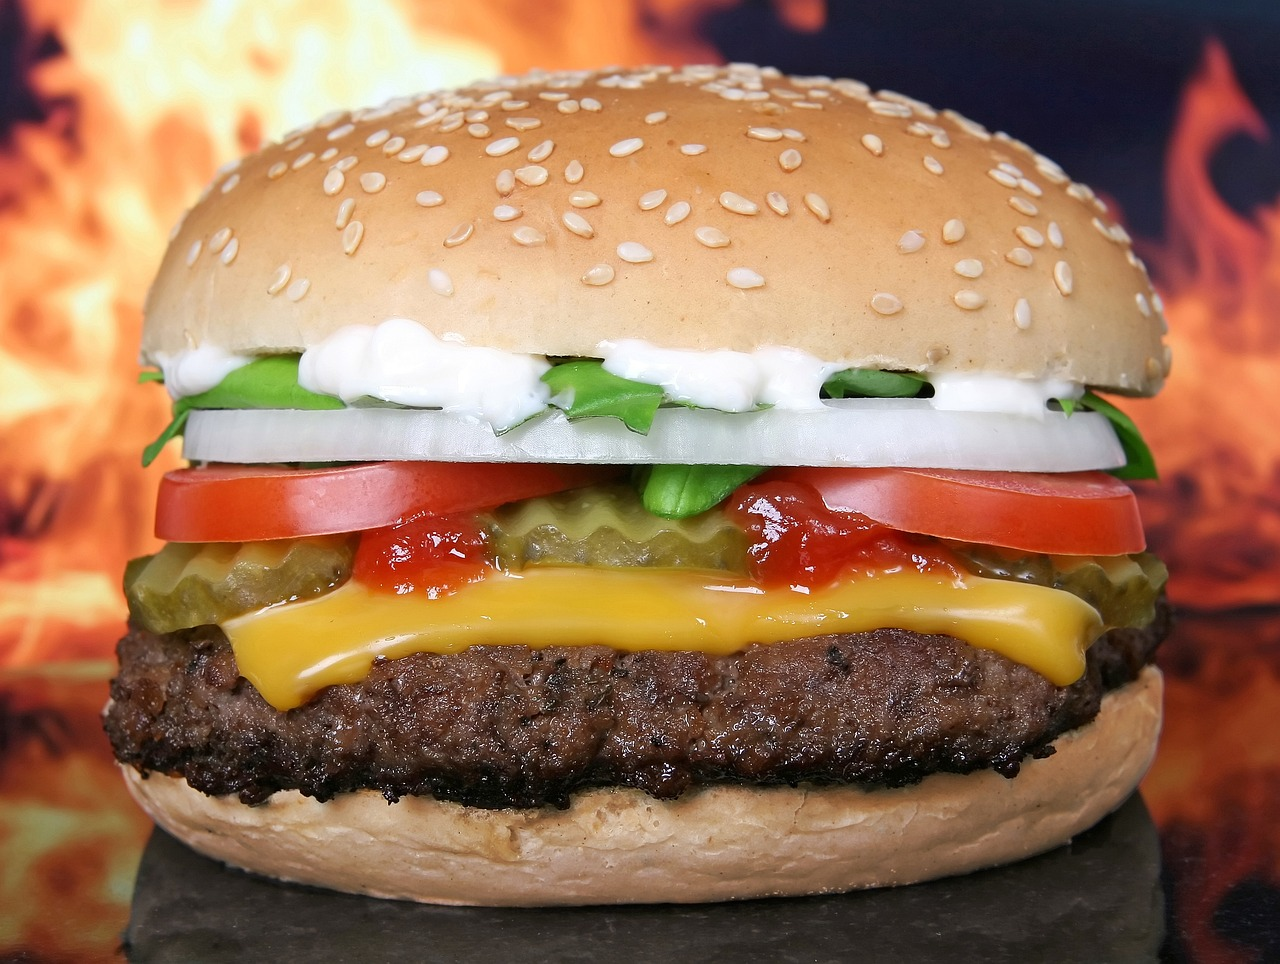

In [18]:
import requests

test_img = Image.open(requests.get("https://cdn.pixabay.com/photo/2016/03/05/19/02/hamburger-1238246_1280.jpg", stream=True).raw).convert("RGB")

test_img

테스트 이미지를 임베딩 하고 작업 확인을 위해 길이를 출력합니다.

In [19]:
test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
test_outputs = model(**test_img_tensor)

test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
test_embedding_list = test_embedding.tolist()

test_embedding.shape

(384,)

주어진 이미지 임베딩과 가장 유사한 이미지를 검색하며 반환되는 결과는 딕셔너리 형태로 query_result 변수에 저장합니다.

In [25]:
query_result = collection.query(
    query_embeddings=[test_embedding_list],
    n_results=5,
)

query_result

{'ids': [['8', '2', '30', '6', '61']],
 'distances': [[153.69615173339844,
   246.11270141601562,
   296.8983154296875,
   298.12811279296875,
   333.6456298828125]],
 'metadatas': [[{'name': 'Bread', 'uri': 'test/Bread/8.jpg'},
   {'name': 'Bread', 'uri': 'test/Bread/2.jpg'},
   {'name': 'Egg', 'uri': 'test/Egg/0.jpg'},
   {'name': 'Bread', 'uri': 'test/Bread/6.jpg'},
   {'name': 'Noodles-Pasta', 'uri': 'test/Noodles-Pasta/1.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'data': None}


query_result에서 반환된 값을 이미지로 시각화합니다.

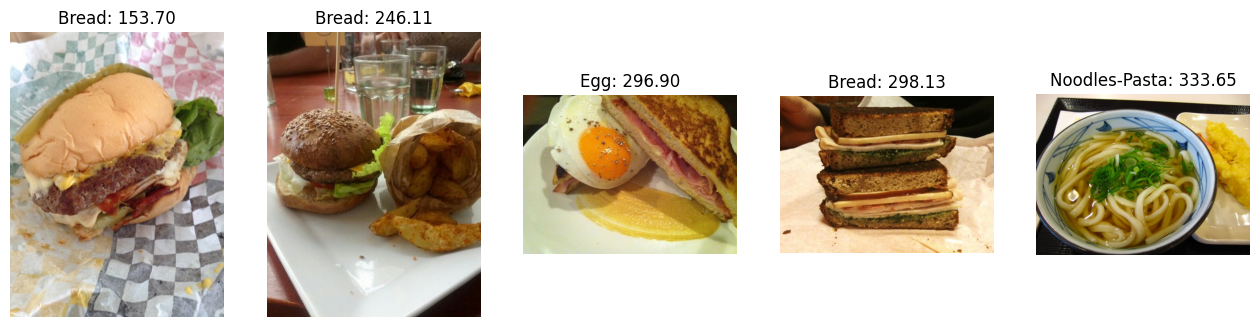

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(16, 10))

for i, metadata in enumerate(query_result["metadatas"][0]):
    distance = query_result["distances"][0][i]

    axes[i].imshow(Image.open(metadata["uri"]))
    axes[i].set_title(f"{metadata['name']}: {distance:.2f}")
    axes[i].axis("off")

## 7. 함수화

In [32]:
def query(img_url, n_results=5):
    test_img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

    test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
    test_outputs = model(**test_img_tensor)

    test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
    test_embedding_list = test_embedding.tolist()

    query_result = collection.query(
        query_embeddings=[test_embedding_list],
        n_results=n_results,
    )

    fig, axes = plt.subplots(1, 6, figsize=(12, 8))

    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]

        axes[i+1].imshow(Image.open(metadata["uri"]))
        axes[i+1].set_title(f"{metadata['name']}: {distance:.2f}")
        axes[i+1].axis("off")

    return query_result

{'ids': [['38', '50', '36', '53', '21']],
 'distances': [[256.1358947753906,
   260.52117919921875,
   264.2164611816406,
   270.1441955566406,
   271.8600158691406]],
 'metadatas': [[{'name': 'Egg', 'uri': 'test/Egg/8.jpg'},
   {'name': 'Meat', 'uri': 'test/Meat/0.jpg'},
   {'name': 'Egg', 'uri': 'test/Egg/6.jpg'},
   {'name': 'Meat', 'uri': 'test/Meat/3.jpg'},
   {'name': 'Dessert', 'uri': 'test/Dessert/1.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'data': None}

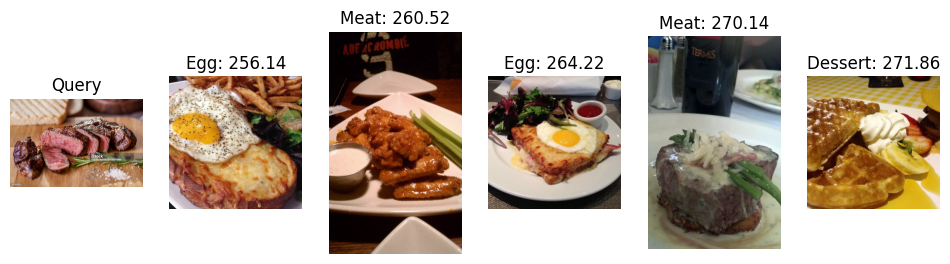

In [33]:
query("https://media.istockphoto.com/id/1472507423/ko/%EC%82%AC%EC%A7%84/%EB%A1%9C%EC%A6%88%EB%A7%88%EB%A6%AC-%ED%9B%84%EC%B6%94-%EC%86%8C%EA%B8%88-%EC%9E%A5%EC%8B%9D%EC%9D%84-%EA%B3%81%EB%93%A4%EC%9D%B8-%EA%B5%AC%EC%9A%B4-%EB%8F%BC%EC%A7%80-%EA%B3%A0%EA%B8%B0-%EC%8A%A4%ED%85%8C%EC%9D%B4%ED%81%AC-%EC%A1%B0%EA%B0%81-%EB%82%98%EB%AC%B4-%ED%8C%90%EC%97%90-%ED%8A%80%EA%B8%B4-%EB%B9%B5-%EC%A1%B0%EA%B0%81-%EC%88%98%ED%8F%89-%EB%B0%A9%ED%96%A5.jpg?s=2048x2048&w=is&k=20&c=D4o0aqVfEKqhQs0sjtWEfvtbeMVvnLZBjAuR_uXcJ4Y=")

{'ids': [['32', '96', '90', '98', '93']],
 'distances': [[249.8357696533203,
   267.87030029296875,
   268.8611145019531,
   285.9063720703125,
   287.51239013671875]],
 'metadatas': [[{'name': 'Egg', 'uri': 'test/Egg/2.jpg'},
   {'name': 'Soup', 'uri': 'test/Soup/6.jpg'},
   {'name': 'Soup', 'uri': 'test/Soup/0.jpg'},
   {'name': 'Soup', 'uri': 'test/Soup/8.jpg'},
   {'name': 'Soup', 'uri': 'test/Soup/3.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'data': None}

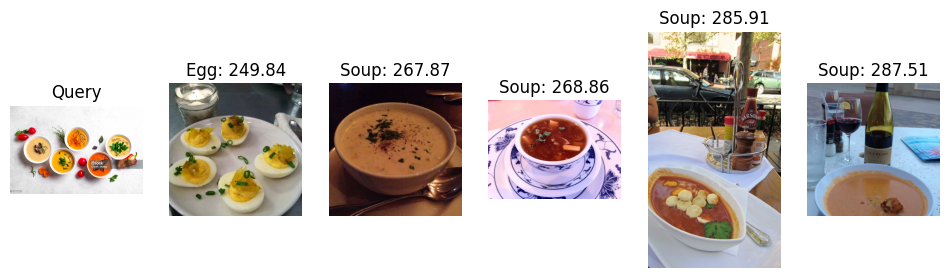

In [34]:
query("https://media.istockphoto.com/id/1643991090/ko/%EC%82%AC%EC%A7%84/%EA%B0%80%EC%9D%84-%EC%95%BC%EC%B1%84-%EC%88%98%ED%94%84-%EC%84%B8%ED%8A%B8.jpg?s=2048x2048&w=is&k=20&c=6lp6eS43PrThk3q6wsYVPvQbUlSg9zhMZR_76xr4rJs=")